In [13]:
from importlib import reload
from time import time
from tqdm import tqdm

import numpy as np
import pandas as pd
import scipy as sc
import torch
import copy

import tdre
import shifts
import assay
import designer
import utils

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [142]:
reload(tdre)
n = 2
d = 20
n_ratio = 4
X0_nxd, Xm_nxd = np.random.randn(n, d), np.random.randn(n, d)
a = tdre.get_mixed_dim_waymarks(X0_nxd, Xm_nxd, n_ratio)
print(a.shape)

Waymark 1 / 3 has 5, 15 dimensions from P0, Pm.
Waymark 2 / 3 has 10, 10 dimensions from P0, Pm.
Waymark 3 / 3 has 15, 5 dimensions from P0, Pm.
(5, 2, 20)


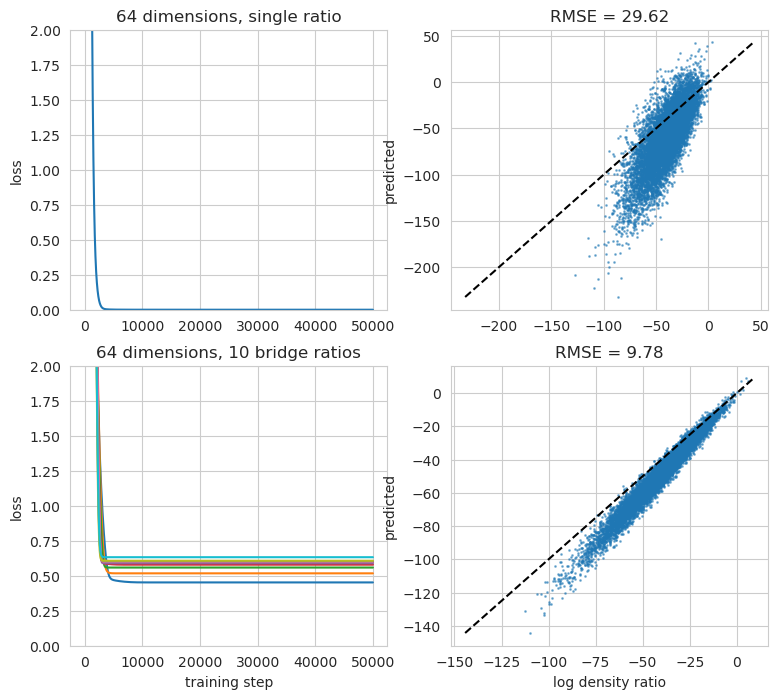

In [90]:
d = 64
m = 10
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.figure(figsize=(9, 8))

plt.subplot(221)
train_dfs = pd.read_csv('hydra_outputs/10-25-2023/11-43/train-0m1-d{}.csv'.format(d), index_col=0)
plt.plot(train_dfs['train_loss']);
plt.ylabel('loss');
plt.title('{} dimensions, single ratio'.format(d));
plt.ylim([0, 2]);

plt.subplot(222)
results = np.load('hydra_outputs/10-25-2023/11-43/m1-d{}.npz'.format(d))
ldr_n = results['ldr_n']
ldrpred_n = results['ldrpred_n']
vmin = np.min(np.hstack([ldr_n, ldrpred_n]))
vmax = np.max(np.hstack([ldr_n, ldrpred_n]))
plt.scatter(ldr_n, ldrpred_n, alpha=0.5, s=1);
plt.plot([vmin, vmax], [vmin, vmax], '--k');
plt.ylabel('predicted');
rmse = np.sqrt(np.mean(np.square(ldr_n - ldrpred_n)))
plt.title('RMSE = {:.2f}'.format(rmse));

plt.subplot(223)
for i in range(m):
    train_dfs = pd.read_csv('hydra_outputs/10-25-2023/11-43/train-{}m{}-d{}.csv'.format(i, m, d), index_col=0)
    plt.plot(train_dfs['train_loss']);
plt.xlabel('training step');
plt.ylabel('loss');
plt.title('{} dimensions, {} bridge ratios'.format(d, m));
plt.ylim([0, 2]);

plt.subplot(224)
results = np.load('hydra_outputs/10-25-2023/11-43/m{}-d{}.npz'.format(m, d))
ldr_n = results['ldr_n']
ldrpred_n = results['ldrpred_n']
vmin = np.min(np.hstack([ldr_n, ldrpred_n]))
vmax = np.max(np.hstack([ldr_n, ldrpred_n]))
plt.scatter(ldr_n, ldrpred_n, alpha=0.5, s=1);
plt.plot([vmin, vmax], [vmin, vmax], '--k');
plt.xlabel('log density ratio');
plt.ylabel('predicted');
rmse = np.sqrt(np.mean(np.square(ldr_n - ldrpred_n)))
plt.title('RMSE = {:.2f}'.format(rmse));



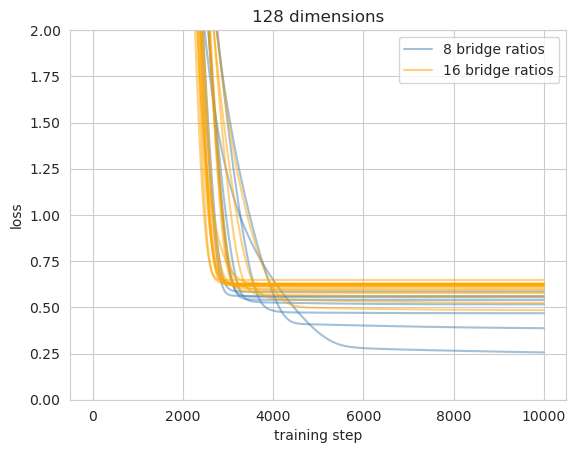

In [107]:

d = 128
for i in range(8):
    train_dfs = pd.read_csv('hydra_outputs/10-25-2023/15-31/train-{}m{}-d{}.csv'.format(i, 8, d), index_col=0)
    plt.plot(train_dfs['train_loss'], c='steelblue', alpha=0.5, label='8 bridge ratios' if i == 0 else '');
    
for i in range(16):
    train_dfs = pd.read_csv('hydra_outputs/10-25-2023/15-31/train-{}m{}-d{}.csv'.format(i, 16, d), index_col=0)
    plt.plot(train_dfs['train_loss'], c='orange', alpha=0.5, label='16 bridge ratios' if i == 0 else '');
plt.xlabel('training step');
plt.ylabel('loss');
plt.title('{} dimensions'.format(d));
plt.ylim([0, 2]);
plt.legend();

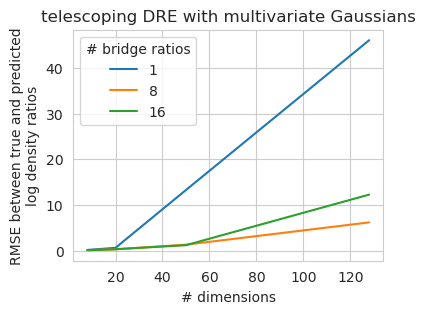

In [96]:
ms = [1, 8, 16]
ds = [8, 20, 50, 128]

rmse_mxd = np.empty([len(ms), len(ds)])
plt.figure(figsize=(4, 3));
for mi, m in enumerate(ms):
    for di, d in enumerate(ds):
        results = np.load('hydra_outputs/10-25-2023/15-31/m{}-d{}.npz'.format(m, d))
        ldr_n = results['ldr_n']
        ldrpred_n = results['ldrpred_n']
        rmse = np.sqrt(np.mean(np.square(ldr_n - ldrpred_n)))
        rmse_mxd[mi, di] = rmse
    plt.plot(ds, rmse_mxd[mi], label=m);    
    
plt.legend(title='# bridge ratios');
# plt.ylim([0, 100]);
plt.xlabel('# dimensions');
plt.ylabel('RMSE between true and predicted\nlog density ratios');
plt.title('telescoping DRE with multivariate Gaussians');

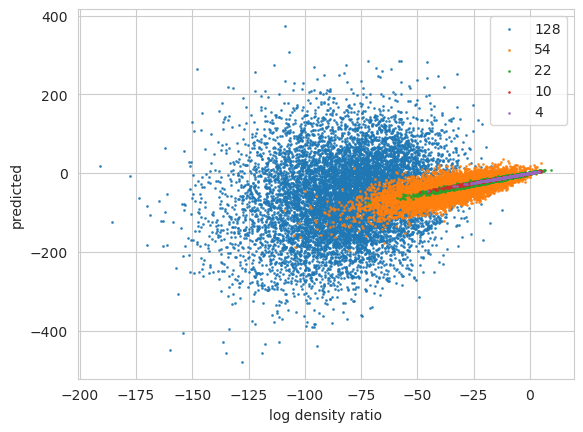

In [51]:
m = 1
for d in [4, 10, 22, 54, 128][::-1]:
    results = np.load('hydra_outputs/10-25-2023/10-27/m{}-d{}.npz'.format(m, d))
    ldr_n = results['ldr_n']
    ldrpred_n = results['ldrpred_n']

    plt.scatter(ldr_n, ldrpred_n, alpha=0.8, s=1, label=d);
    plt.xlabel('log density ratio');
    plt.ylabel('predicted');
plt.legend();

Generated 3 waymarks.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:13<00:00, 732.20it/s]


Done fitting bridge 1 / 3 (13 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:12<00:00, 773.22it/s]


Done fitting bridge 2 / 3 (26 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:12<00:00, 778.22it/s]


Done fitting bridge 3 / 3 (39 s).


Text(0.5, 1.0, 'RMSE = 0.78')

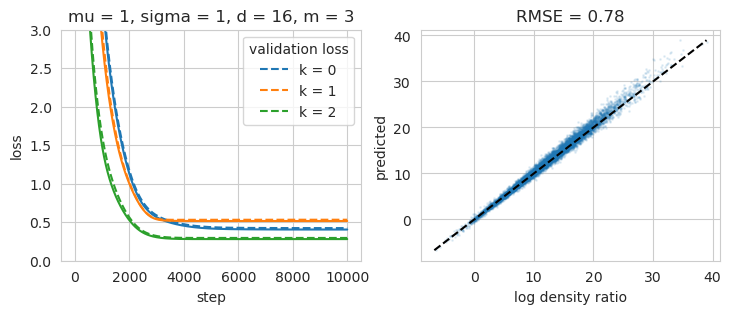

In [12]:
reload(tdre)
reload(shifts)
d = 16
sigma = 1
mu = 1
n = 10000
m = 3
device = torch.device('cuda')
dtype = torch.float

config = {
    'val_frac': 0.1,
    'n_steps': 10000,
    'lr': 1e-3,
}


# get samples from p0 (target) and pm (source)
ds = shifts.MultivariateGaussians(d, mu=mu)
Xm_nxd, X0_nxd = ds.get_data(n)

# fit bridges
model = tdre.UnsharedQuadraticTelescopingLogDensityRatioEstimator(
    tdre.Quadratic, d, n_ratio=m, device=device, dtype=dtype)
train_dfs = model.fit(X0_nxd, Xm_nxd, config) 

Xm_nxd, X0_nxd = ds.get_data(n)
ldrpred_n = model.predict_log_dr(Xm_nxd)
ldr_n = ds.get_log_dr(Xm_nxd)
rmse = np.sqrt(np.mean(np.square(ldr_n - ldrpred_n)))

# plot
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.figure(figsize=(8.5, 3))

plt.subplot(121)
for i in range(m):
    plt.plot(train_dfs[i]['train_loss'], c=colors[i]);
    plt.plot(train_dfs[i]['val_loss'], '--', c=colors[i], label='k = {}'.format(i));
plt.legend(title='validation loss');
plt.xlabel('step');
plt.ylabel('loss');
plt.title('mu = {}, sigma = {}, d = {}, m = {}'.format(mu, sigma, d, m));
plt.ylim([0, 3]);

plt.subplot(122)
vmin = np.min(np.hstack([ldr_n, ldrpred_n]))
vmax = np.max(np.hstack([ldr_n, ldrpred_n]))
plt.scatter(ldr_n, ldrpred_n, alpha=0.1, s=1);
plt.plot([vmin, vmax], [vmin, vmax], '--k');
plt.xlabel('log density ratio');
plt.ylabel('predicted');
plt.title('RMSE = {:.2f}'.format(rmse));


In [206]:
reload(tdre)
reload(shifts)
d = 128
p = 0.3
n = 10000
m = 8
device = torch.device('cuda')
dtype = torch.float

config = {
    'waymark_type': 'linear',
    'val_frac': 0,
    'n_steps': 10000,
    'lr': 1e-3,
}


# get samples from p0 (target) and pm (source)
ds = shifts.DiscreteSequences(d, p=p)
Xm_nxd, X0_nxd = ds.get_data(n)

# fit bridges
model = tdre.UnsharedTelescopingLogDensityRatioEstimator(
    tdre.Linear, d, n_ratio=m, device=device, dtype=dtype)
train_dfs = model.fit(X0_nxd, Xm_nxd, config) 

Xm_nxd, X0_nxd = ds.get_data(n)
ldrpred_n = model.predict_log_dr(Xm_nxd)
ldr_n = ds.get_log_dr(Xm_nxd)
rmse = np.sqrt(np.mean(np.square(ldr_n - ldrpred_n)))

Generated 8 waymarks.
No validation data for bridge.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1151.36it/s]


Done fitting bridge 1 / 8 (8 s).
No validation data for bridge.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1199.35it/s]


Done fitting bridge 2 / 8 (17 s).
No validation data for bridge.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1199.36it/s]


Done fitting bridge 3 / 8 (25 s).
No validation data for bridge.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1187.80it/s]


Done fitting bridge 4 / 8 (33 s).
No validation data for bridge.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1205.41it/s]


Done fitting bridge 5 / 8 (42 s).
No validation data for bridge.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1204.42it/s]


Done fitting bridge 6 / 8 (50 s).
No validation data for bridge.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1180.97it/s]


Done fitting bridge 7 / 8 (58 s).
No validation data for bridge.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1190.27it/s]


Done fitting bridge 8 / 8 (67 s).


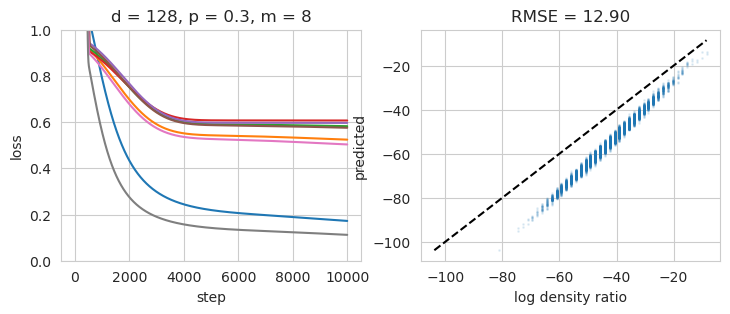

In [207]:

plt.figure(figsize=(8.5, 3))
plt.subplot(121)
for i in range(m):
    plt.plot(train_dfs[i]['train_loss']);
plt.xlabel('step');
plt.ylabel('loss');
plt.title('d = {}, p = {}, m = {}'.format(d, p, m));
plt.ylim([0, 1]);

plt.subplot(122)
vmin = np.min(np.hstack([ldr_n, ldrpred_n]))
vmax = np.max(np.hstack([ldr_n, ldrpred_n]))
plt.scatter(ldr_n, ldrpred_n, alpha=0.1, s=1);
plt.plot([vmin, vmax], [vmin, vmax], '--k');
plt.xlabel('log density ratio');
plt.ylabel('predicted');
plt.title('RMSE = {:.2f}'.format(rmse));


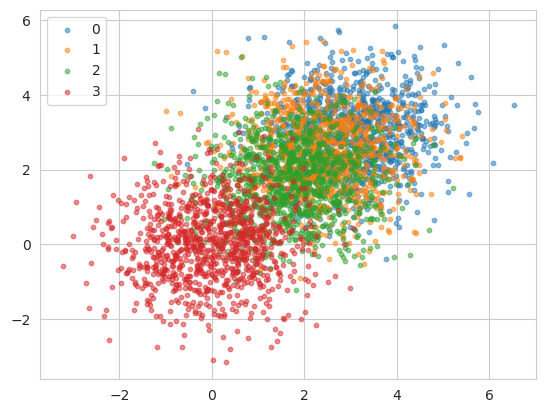

In [83]:
# visualize waymarks 
n = 1000
d = 2
m = 3
mu = 3
sigma = 1
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


Xm_nxd, X0_nxd = get_data_diff_means(n, d, sigma=sigma, mu=mu)
a_m1 = get_alphas(m)
X_m1xnxd = get_waymark_samples(X0_nxd, Xm_nxd, a_m1)

# plt.scatter(X_m1xnxd[0, :, 0], X_m1xnxd[0, :, 1], alpha=0.5, s=10)
for i in range(0, m + 1):
    plt.scatter(X_m1xnxd[i, :, 0], X_m1xnxd[i, :, 1],
                alpha=0.5, s=10, label=i, color=colors[i]);
# plt.scatter(X_m1xnxd[-1, :, 0], X_m1xnxd[-1, :, 1], alpha=0.5, s=10);
plt.legend()
